In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


[I 2024-08-04 18:19:15,389] A new study created in memory with name: no-name-21ebc3ff-e16d-46e7-a525-d4db49b92226
[I 2024-08-04 18:19:15,833] Trial 0 finished with value: 85.92972975328261 and parameters: {'n_estimators': 398, 'learning_rate': 0.02202236739679641, 'max_depth': 5, 'subsample': 0.7371765561582494, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 85.92972975328261.
[I 2024-08-04 18:19:16,286] Trial 1 finished with value: 133.75256875501628 and parameters: {'n_estimators': 435, 'learning_rate': 0.19418876984383587, 'max_depth': 4, 'subsample': 0.6318946070226972, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 85.92972975328261.
[I 2024-08-04 18:19:16,420] Trial 2 finished with value: 102.95087820845585 and parameters: {'n_estimators': 91, 'learning_rate': 0.17358379261950763, 'max_depth': 5, 'subsample': 0.8541802486369376, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 85.92972975328261.


Best Parameters: {'n_estimators': 76, 'learning_rate': 0.01921929525753531, 'max_depth': 8, 'subsample': 0.6475248080667659, 'min_samples_split': 7, 'min_samples_leaf': 10}
Mean Squared Error with Gradient Boosting: 33.98036637503136
R^2 Score with Gradient Boosting: -0.10828340639739276
                       Feature  Importance
7                       Veggie    0.310508
5       Farmers' markets, 2018    0.197428
2                    Fast Food    0.167780
3                        Soda     0.124597
4         Grocery stores, 2016    0.082695
6                       Fruit     0.064996
1  Fast-food restaurants, 2016    0.032314
0     Convenience stores, 2016    0.019682


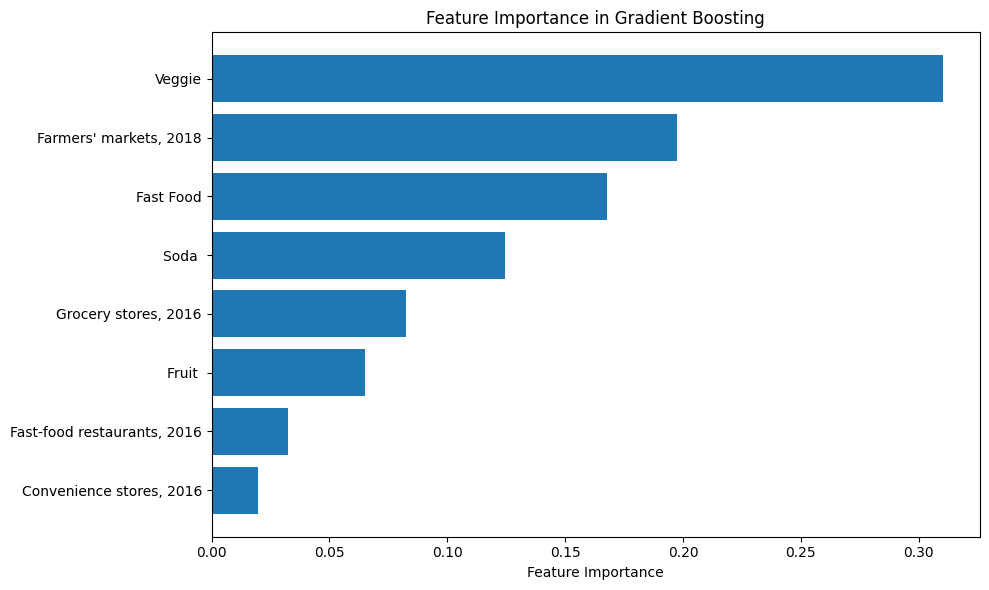

In [10]:
import optuna
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess the data
df = pd.read_csv('modified_california_counties.csv')
df = df.dropna()
# Select top features based on previous importance
top_features = ['Convenience stores, 2016', 'Fast-food restaurants, 2016', 'Fast Food',
                'Soda ', 'Grocery stores, 2016', 'Farmers\' markets, 2018', 'Fruit ', 'Veggie']
X = df[top_features]
y = df['Obese']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print(f"Best Parameters: {study.best_params}")

# Train the best model
best_params = study.best_params
best_gb = GradientBoostingRegressor(**best_params, random_state=42)
best_gb.fit(X_train, y_train)

# Predict and evaluate the best model
y_pred = best_gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#print(f"Mean Squared Error with Gradient Boosting: {mse}")
#print(f"R^2 Score with Gradient Boosting: {r2}")

# Feature importance
importances = best_gb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': top_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
#print(feature_importance_df)

# Plot feature importance
#plt.figure(figsize=(10, 6))
#plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
#plt.xlabel('Feature Importance')
#plt.title('Feature Importance in Gradient Boosting')
#plt.gca().invert_yaxis()
#plt.tight_layout()
#plt.savefig('feature_importance_county.png')
#plt.show()

# Function to experiment with variable changes in a specific county
def predict_obesity_for_county(county_name, variable_changes):
    county_data = df[df['County'] == county_name]
    if county_data.empty:
        print(f'County {county_name} not found in the dataset.')
        return

    # Original prediction
    original_obesity = best_gb.predict(scaler.transform(county_data[top_features]))[0]

    # Apply changes to the specified variables
    county_data = county_data[top_features].copy()
    for variable, change in variable_changes.items():
        if variable in county_data.columns:
            county_data[variable] += change
        else:
            print(f'Variable {variable} not found in the dataset.')
            return

    # New prediction after changes
    new_obesity = best_gb.predict(scaler.transform(county_data))[0]
    change_in_obesity = new_obesity - original_obesity

    return original_obesity, new_obesity, change_in_obesity


In [ ]:
# Example usage
county_name = 'Alameda'
variable_changes = {
    'Convenience stores, 2016': 0,
    'Fast-food restaurants, 2016': 0,
    'Fast Food': 0,
    'Soda ': 0,
    'Grocery stores, 2016': 0,
    'Farmers\' markets, 2018': 0,
    'Fruit ': 0,
    'Veggie': 0'
}
original_obesity, new_obesity, change_in_obesity = predict_obesity_for_county(county_name, variable_changes)
print(f'Original obesity for {county_name}: {original_obesity}')
print(f'New predicted obesity for {county_name} after changes: {new_obesity}')
print(f'Change in obesity for {county_name} after changes: {change_in_obesity}')
